In [1]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read, Split train_val & oversample train set


In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']
df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.1, random_state = 415);
train_df.head()

,Image name,Retinopathy grade
118,IDRiD_119,4
391,IDRiD_392,4
41,IDRiD_042,2
44,IDRiD_045,2
216,IDRiD_217,0


In [4]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 371


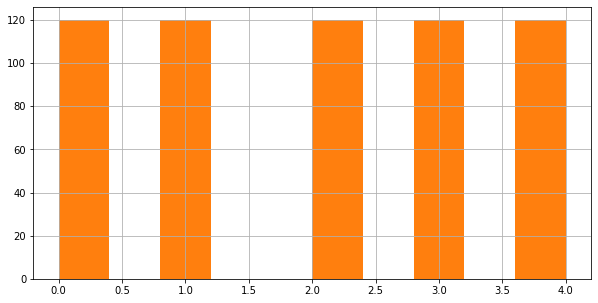

In [5]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import multiprocessing

train_datagen = ImageDataGenerator(
    shear_range=0.05,
    zoom_range=0.05,
    rotation_range=6,
    horizontal_flip=True,
    vertical_flip=True)

In [16]:
image_names = train_df['Image name'];
im_size = 224;

train_labels = [];
for label in train_df['Retinopathy grade']:
    for i in range(2): # 5 times for data augmentation
      train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((2*len(train_df['Image name']),224,224,3))
#train_images= np.zeros((len(train_df['Image name']),224,224,3))
#rot=[-6,-5,-4,-3,-2,2,3,4,5,6]
index=0
for image_name in image_names:
    #read image
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index] = img
    #train_images[index + 1] = np.flip(img, axis = 0)
    #train_images[index + 2] = np.flip(img, axis = 1)
    train_images[index + 1] = np.rot90(np.rot90(img))
    #train_images[index + 4] = scipy.ndimage.rotate(img, random.choice(rot), reshape = False)
    #index = index + 5
    index = index + 2

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  1200
(1200, 224, 224, 3)
(1200, 5)


array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0]])

In [17]:
train_datagen.fit(train_images)

## Read and undersample test_df

---




In [18]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


In [19]:
#undersample
#test_df = balance_data(test_df.pivot_table(index='Retinopathy grade', aggfunc=len).min().min(),test_df) # I will oversample such that all classes have the same number of images as the maximum
#test_df['Retinopathy grade'].hist(figsize = (10, 5))

In [20]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 224;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = cv2.imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

#enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 224, 224, 3)
(103, 5)


In [21]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of test set ",len(val_image_names))
im_size = 224;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);

val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of test set  42
(42, 224, 224, 3)
(42, 5)


In [22]:
from sklearn.utils import shuffle

train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (1200, 224, 224, 3)
train y size  (1200, 5)
test x size  (103, 224, 224, 3)
test y size  (103, 5)
val x size  (42, 224, 224, 3)
val y size  (42, 5)


In [35]:
from keras.models import Sequential
#from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import model_from_json
#base_model = ResNet50(include_top=False,weights=None,input_shape=(224,224,3))

json_file = open("/content/drive/My Drive/IDRid/model_gradingNew.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

base_model=model_from_json(loaded_model_json)
base_model.load_weights("/content/drive/My Drive/IDRid/model_gradingNew.h5")

In [ ]:
#base_model.summary()

In [36]:
layers=base_model.layers
last_layers=[]
#add last layers name
for i in range(14):
  last_layers.append(layers[-i-1].name)

set_trainable = False
for layer in base_model.layers:
    if layer.name in last_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(15)

,Layer Type,Layer Name,Layer Trainable
213,<tensorflow.python.keras.layers.core.Dropout o...,dropout_96,False
214,<tensorflow.python.keras.layers.convolutional....,conv2d_104,True
215,<tensorflow.python.keras.layers.normalization_...,batch_normalization_104,True
216,<tensorflow.python.keras.layers.core.Activatio...,activation_96,True
217,<tensorflow.python.keras.layers.core.Dropout o...,dropout_97,True
218,<tensorflow.python.keras.layers.convolutional....,conv2d_105,True
219,<tensorflow.python.keras.layers.normalization_...,batch_normalization_105,True
220,<tensorflow.python.keras.layers.merge.Add obje...,add_31,True
221,<tensorflow.python.keras.layers.core.Activatio...,activation_97,True
222,<tensorflow.python.keras.layers.core.Dropout o...,dropout_98,True


In [ ]:
"""
output=base_model.layers[-3].output
model_wot=Model(base_model.input,output)
model= Sequential()#
model.add(model_wot)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.summary()"""

In [37]:
output=Dense(256, activation='relu')(base_model.layers[-3].output)
output=Dropout(0.1)(output)
output=Dense(5, activation='softmax')(output)
model=Model(base_model.input,output)

In [38]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 28,307,845
Trainable params: 8,135,685
Non-trainable params: 20,172,160


In [39]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 10)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 100, validation_data = (val_images, val_labels), callbacks = [early_stopping], shuffle = True);

Epoch 1/100
75/75 [==============================] - 25s 262ms/step - loss: 2.1857 - accuracy: 0.3101 - val_loss: 1.5907 - val_accuracy: 0.3333
Epoch 2/100
75/75 [==============================] - 19s 246ms/step - loss: 1.2775 - accuracy: 0.4644 - val_loss: 1.2156 - val_accuracy: 0.4762
Epoch 3/100
75/75 [==============================] - 19s 245ms/step - loss: 1.1001 - accuracy: 0.5540 - val_loss: 1.3516 - val_accuracy: 0.4762
Epoch 4/100
75/75 [==============================] - 19s 246ms/step - loss: 1.0407 - accuracy: 0.5838 - val_loss: 1.6339 - val_accuracy: 0.3810
Epoch 5/100
75/75 [==============================] - 19s 248ms/step - loss: 0.9349 - accuracy: 0.6504 - val_loss: 1.6902 - val_accuracy: 0.3333
Epoch 6/100
75/75 [==============================] - 19s 248ms/step - loss: 0.9172 - accuracy: 0.6205 - val_loss: 1.4689 - val_accuracy: 0.5000
Epoch 7/100
75/75 [==============================] - 19s 246ms/step - loss: 0.8012 - accuracy: 0.7047 - val_loss: 1.3407 - val_accuracy:

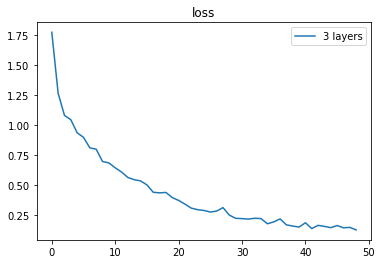

In [40]:
plt.plot(hist.history['loss'][0:],label="{} layers".format(3))
plt.legend()
plt.title('loss')
plt.show()

4/4 [==============================] - 1s 165ms/step - loss: 3.1337 - accuracy: 0.3981
Loss = 3.1337180137634277
Test accuracy = 0.3980582654476166
[[19  1  9  2  3]
 [ 4  0  1  0  0]
 [ 7  2 11  6  6]
 [ 4  0  2  8  5]
 [ 6  0  2  2  3]]


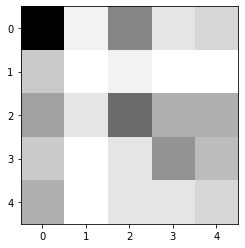

In [41]:
preds = model.evaluate(test_images, test_labels)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))
pred_y_=model.predict(test_images)
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')

[[14  0  0  0  0]
 [ 0  0  0  0  0]
 [ 4  0  7  4  4]
 [ 1  0  2  0  2]
 [ 0  1  0  0  3]]
0.5714285714285714  acuracy


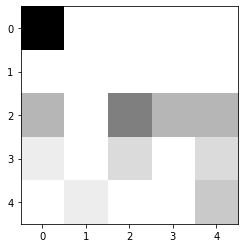

In [42]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=model.predict(val_images)
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary') 
score=accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

[[231   0   9   0   0]
 [  7 209  10   8   6]
 [  4   1 235   0   0]
 [  4   0   8 225   3]
 [  0   0   0   8 232]]


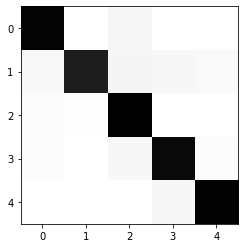

In [43]:
pred_y_=model.predict(train_images)
cm=confusion_matrix(np.argmax(train_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary') 

In [44]:
score=accuracy_score(np.argmax(train_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

0.9433333333333334  acuracy


## Unfreeze and retrain whole network

In [45]:
model.trainable=True
for layer in model.layers:
  if layer.name[0:5]=='batch':
    layer.trainable=False
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 28,307,845
Trainable params: 28,201,605
Non-trainable params: 106,240


In [46]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate = 1e-8, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 10, validation_data = (val_images, val_labels), shuffle = True);

Epoch 1/10
75/75 [==============================] - 44s 497ms/step - loss: 0.1022 - accuracy: 0.9674 - val_loss: 2.4987 - val_accuracy: 0.5714
Epoch 2/10
75/75 [==============================] - 36s 480ms/step - loss: 0.0980 - accuracy: 0.9728 - val_loss: 2.5005 - val_accuracy: 0.5714
Epoch 3/10
75/75 [==============================] - 36s 480ms/step - loss: 0.0897 - accuracy: 0.9766 - val_loss: 2.4993 - val_accuracy: 0.5714
Epoch 4/10
75/75 [==============================] - 36s 479ms/step - loss: 0.0901 - accuracy: 0.9814 - val_loss: 2.4983 - val_accuracy: 0.5714
Epoch 5/10
75/75 [==============================] - 36s 481ms/step - loss: 0.0879 - accuracy: 0.9706 - val_loss: 2.4971 - val_accuracy: 0.5714
Epoch 6/10
75/75 [==============================] - 36s 481ms/step - loss: 0.1079 - accuracy: 0.9673 - val_loss: 2.4969 - val_accuracy: 0.5714
Epoch 7/10
75/75 [==============================] - 36s 482ms/step - loss: 0.0865 - accuracy: 0.9734 - val_loss: 2.4973 - val_accuracy: 0.5714

4/4 [==============================] - 1s 169ms/step - loss: 3.1311 - accuracy: 0.4175
Loss = 3.131082773208618
Test accuracy = 0.41747573018074036
[[19  1  9  2  3]
 [ 4  0  1  0  0]
 [ 7  2 13  4  6]
 [ 4  0  2  8  5]
 [ 6  0  2  2  3]]


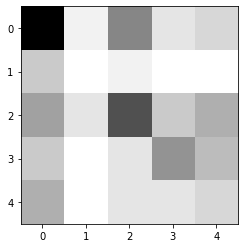

In [47]:
preds = model.evaluate(test_images, test_labels)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))
pred_y_=model.predict(test_images)
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')